
<!-- README.md is generated from README.ipynb. Please edit that file -->

# pyramid-learn <img src="docs/logo/logo_hex.png" align="right" height="138"/>

A [{rpy2}](https://rpy2.github.io/doc/latest/html/)-based Python wrapper for the [{midr}](https://ryo-asashi.github.io/midr/) R package to explain black-box models, with a [{scikit-learn}](https://scikit-learn.org/stable/) compatible API.

The goal of {midr} is to provide a model-agnostic method for interpreting and explaining black-box predictive models by creating a globally interpretable surrogate model.
The package implements 'Maximum Interpretation Decomposition' (MID), a functional decomposition technique that finds an optimal additive approximation of the original model.
This approximation is achieved by minimizing the squared error between the predictions of the black-box model and the surrogate model.
The theoretical foundations of MID are described in Iwasawa & Matsumori (2025) \[Forthcoming\], and the package itself is detailed in [Asashiba et al. (2025)](https://arxiv.org/abs/2506.08338).

## Installation

You can install the package directly from GitHub:

```bash
pip install git+https://github.com/ryo-asashi/pyramid-learn.git
```

## Features

- **Scikit-learn Compatible API**: Fits seamlessly into your existing 'scikit-learn' workflows with a familiar .fit() and .predict() interface.

- **Model-Agnostic IML**: Explains any black-box model, from complex neural networks to gradient boosting machines.

- **Global Interpretability**: Generates a simple, additive surrogate model (MID) that provides a global understanding of the black-box model's behavior.

- **Direct Visualizations**: Easily creates plots for feature importance, component functions (dependence), prediction breakdowns, and conditional expectations using a plotnine-based interface.

## Requirements

This package is a {rpy2}-based Python wrapper and requires a working R installation on your system, as well as the {midr} R package.

You can install the R package from CRAN by running the following command in your R console:

```r
install.packages('midr')
```

## Quick Start

Here’s a basic example of how to use **pyramid-learn** (namespace: **midlearn**) to explain a trained LightGBM model.

In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.datasets import fetch_openml
from sklearn import set_config

import lightgbm as lgb
import midlearn as mid 

# Set up plotnine theme for clean visualizations
import plotnine as p9 # require plotnine >= 0.15.0
p9.theme_set(p9.theme_538(base_family='serif'))

# Configure scikit-learn display
set_config(display='text')

## 1. Train a Black-Box Model
We use the California Housing dataset to train a LightGBM Regressor, which will serve as our black-box model.

In [78]:
# Load and prepare data
bikeshare = fetch_openml(data_id=42712)
X = pd.DataFrame(bikeshare.data, columns=bikeshare.feature_names)
y = bikeshare.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Fit a LightGBM regression model
estimator = lgb.LGBMRegressor(
    force_col_wise=True,
    n_estimators=500,
    random_state=42
)
estimator.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 13034, number of used features: 12
[LightGBM] [Info] Start training from score 190.379623


LGBMRegressor(force_col_wise=True, n_estimators=500, random_state=42)

In [79]:
model_pred = estimator.predict(X_test)
rmse = root_mean_squared_error(model_pred, y_test)
print(f"RMSE: {round(rmse, 6)}")

RMSE: 37.615267


## 2. Create an Explaination Model
We fit the `MIDExplainer` to the training data to create a globally faithful, interpretable surrogate model (MID).

In [80]:
# Initialize and fit the MID model
explainer = mid.MIDExplainer(
    estimator=estimator,
    penalty=.05,
    singular_ok=True,
    interactions=True,
    encoding_frames={'hour':list(range(24))}
)
explainer.fit(X_train)

Generating predictions from the estimator...


R callback write-console: singular fit encountered
  


MIDExplainer(encoding_frames={'hour': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23]},
             estimator=LGBMRegressor(force_col_wise=True, n_estimators=500,
                                     random_state=42),
             penalty=0.05, singular_ok=True)

Generating predictions from the estimator...


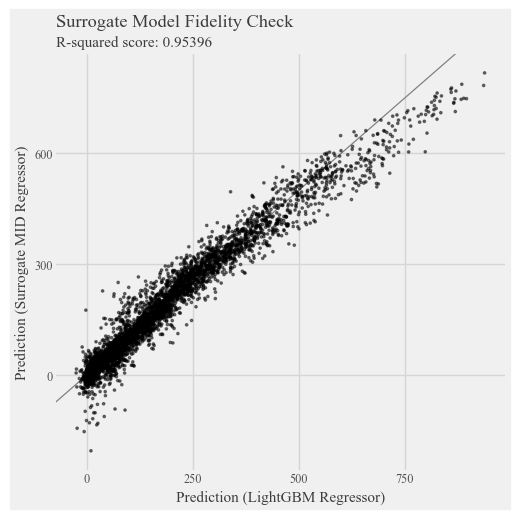

In [81]:
# Check the fidelity of the surrogate model to the original model
p = p9.ggplot() \
    + p9.geom_abline(slope=1, color='gray') \
    + p9.geom_point(p9.aes(estimator.predict(X_test), explainer.predict(X_test)), alpha=0.5, shape=".") \
    + p9.labs(
        x='Prediction (LightGBM Regressor)',
        y='Prediction (Surrogate MID Regressor)',
        title='Surrogate Model Fidelity Check',
        subtitle=f'R-squared score: {round(explainer.fidelity_score(X_test), 6)}',
    )
display(p + p9.theme(figure_size=(5,5)))

## 3. Visualize the Explanation Model
The MID model allows for clear visualization of feature importance, individual effects, and local prediction breakdowns.

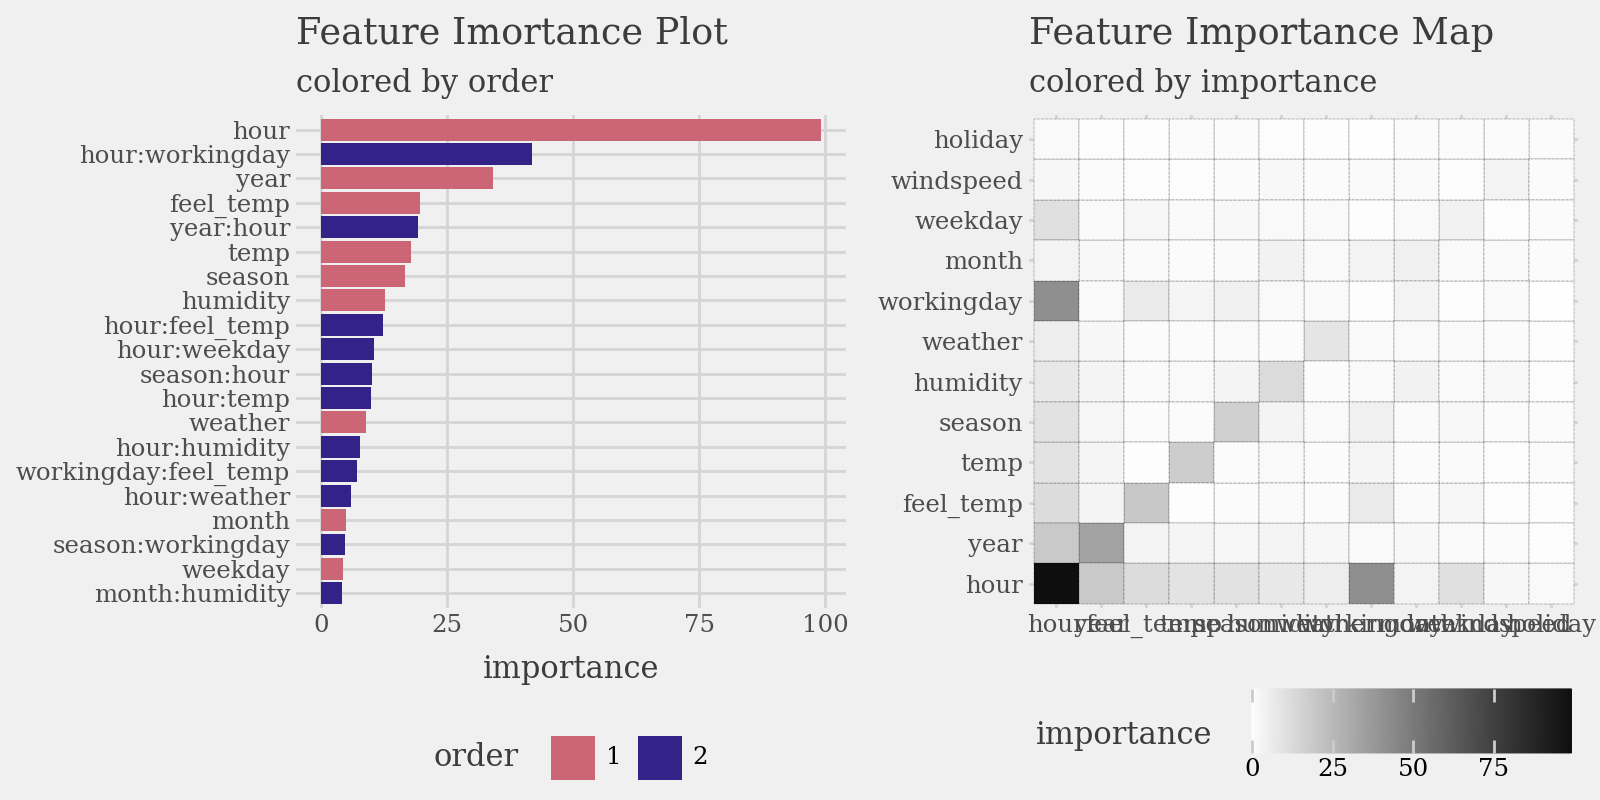

In [82]:
# Calculate and plot overall feature importance (default bar plot and heatmap)
imp = explainer.importance()
p1 = (
    imp.plot(max_nterms=20, theme="muted") +
    p9.labs(title="Feature Imortance Plot", subtitle="colored by order")
)
p2 = (
    imp.plot(style='heatmap', color='black', linetype='dotted') +
    p9.labs(title="Feature Importance Map", subtitle="colored by importance")
)
display((p1 | p2) & p9.theme(figure_size=(8, 4), legend_position="bottom"))

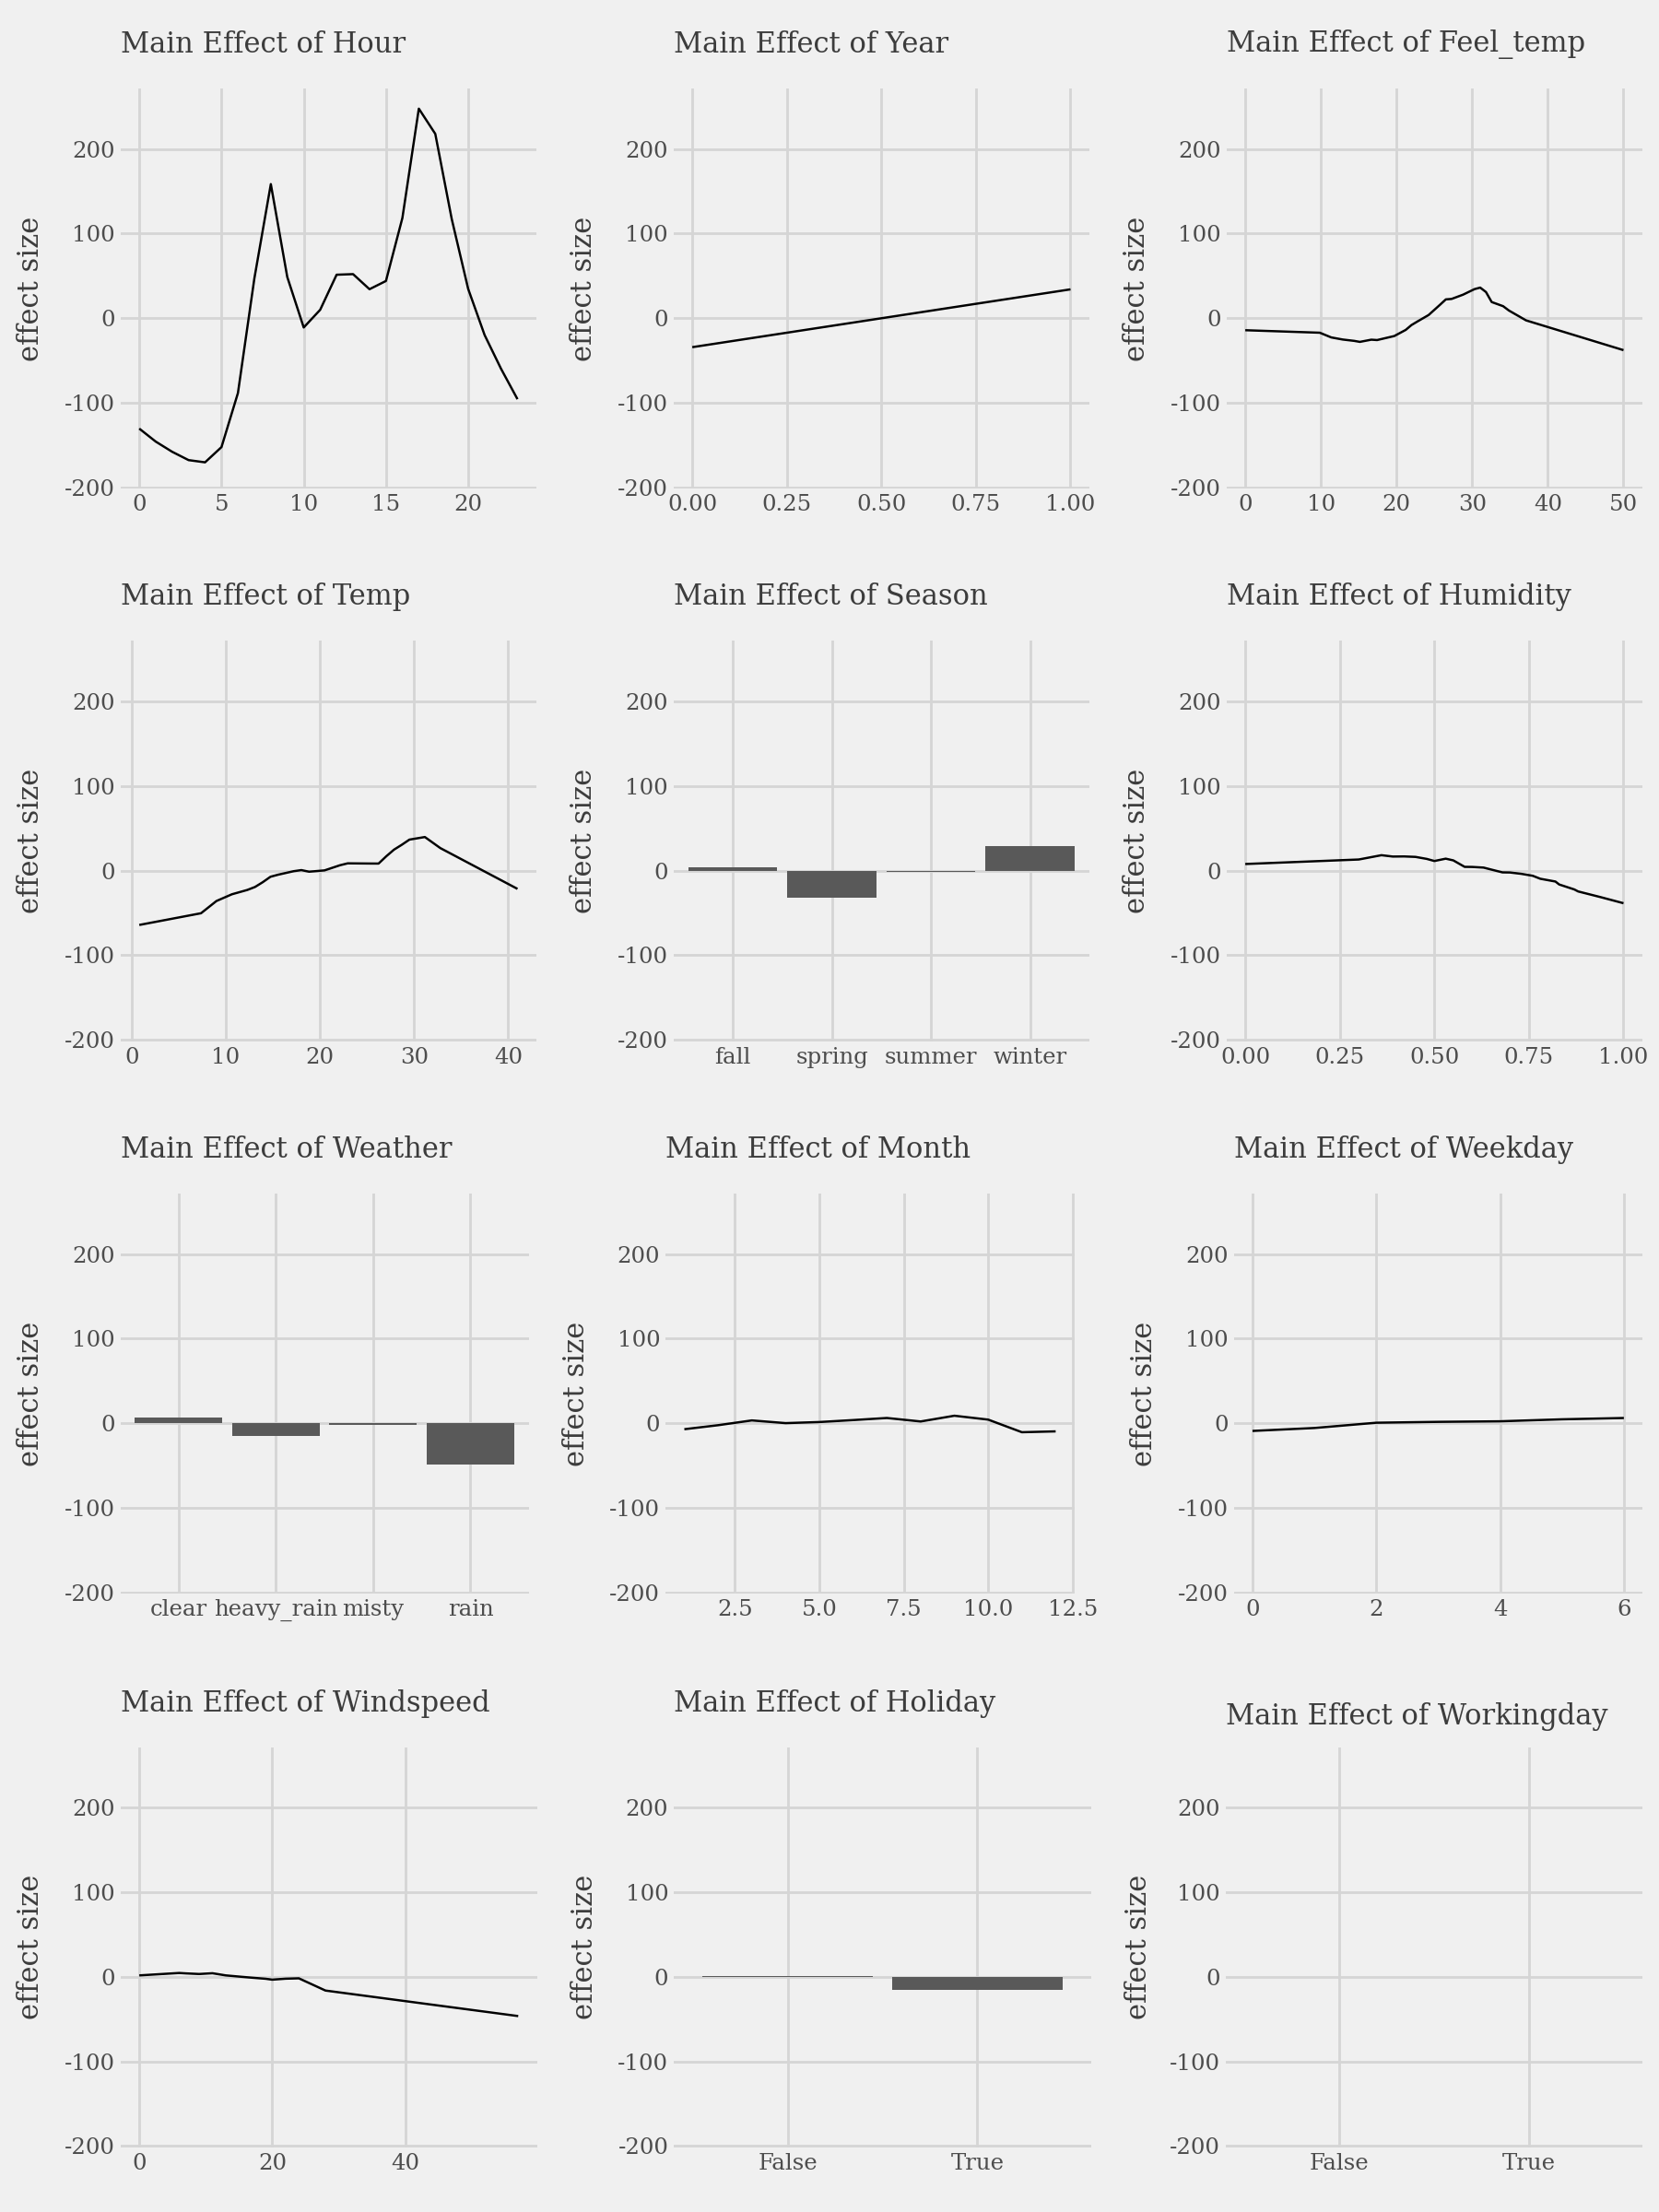

In [83]:
# Plot the top 3 important main effects (Component Functions)
plots = list()
for i, t in enumerate(imp.terms(interactions=False)):
    p = (
        explainer.plot(term=t) +
        p9.lims(y=[-180, 250]) +
        p9.labs(
            subtitle=f"Main Effect of {t.capitalize()}",
            x="",
            y="effect size"
        )
    )
    plots.append(p)

p1 = (
    (plots[0] | plots[1] | plots[2]) /
    (plots[3] | plots[4] | plots[5]) /
    (plots[6] | plots[7] | plots[8]) /
    (plots[9] | plots[10] | plots[11])
)
display(p1 + p9.theme(figure_size=(9, 12)))

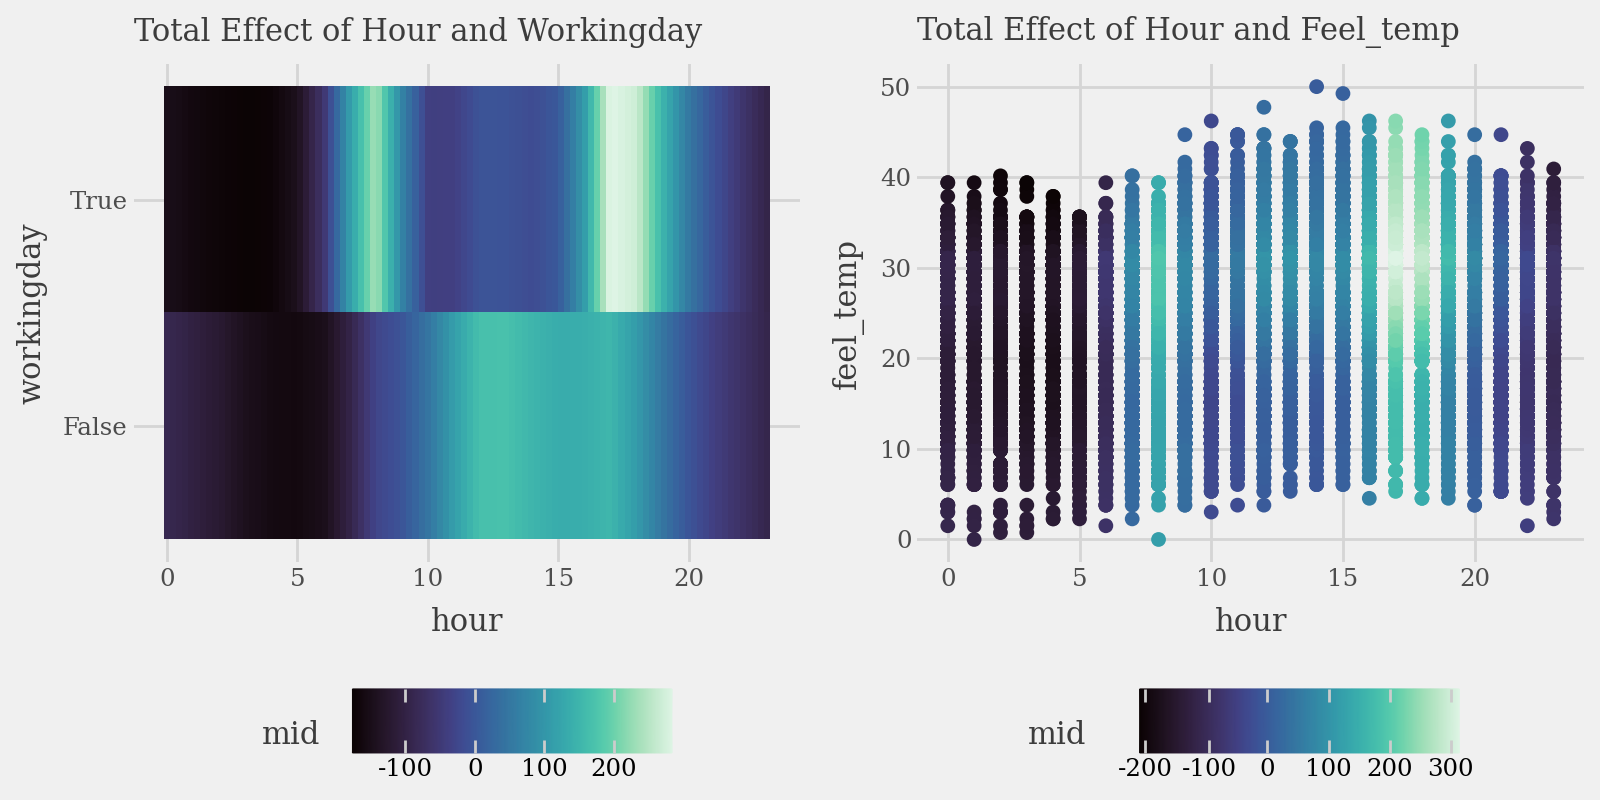

In [84]:
# Plot the interaction of pairs of variables (Component Functions)
p1 = (
    explainer.plot(
        "hour:workingday",
        theme='mako',
        main_effects=True
    ) +
    p9.labs(subtitle="Total Effect of Hour and Workingday")
)
p2 = (
    explainer.plot(
        "hour:feel_temp",
        style='data',
        theme='mako',
        data=X_train,
        main_effects=True,
        size=2
    ) +
    p9.labs(subtitle="Total Effect of Hour and Feel_temp")
)
display((p1 | p2) & p9.theme(figure_size=(8, 4), legend_position="bottom"))

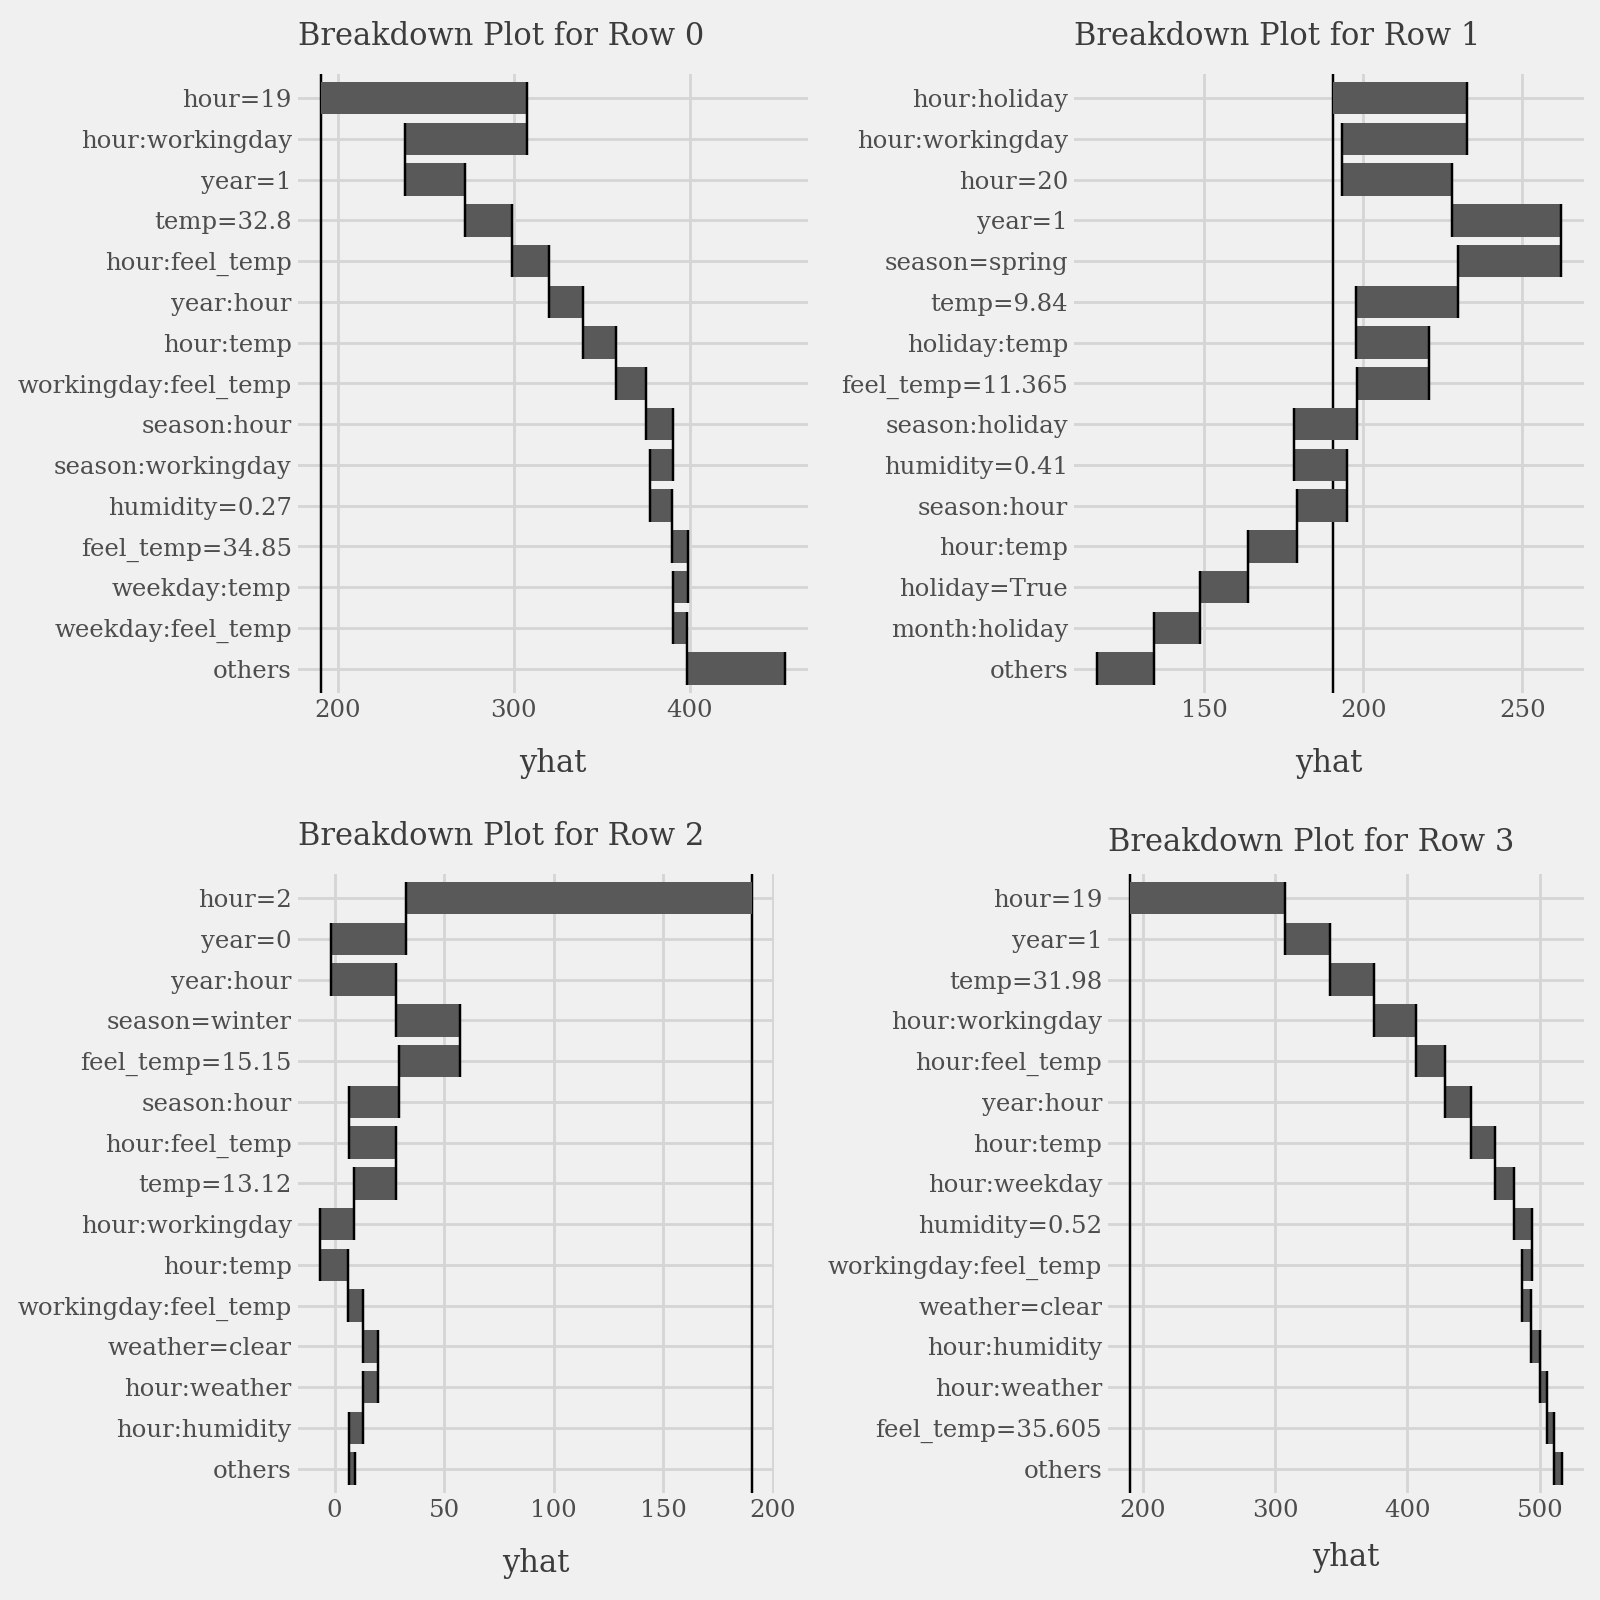

In [85]:
# Plot prediction breakdowns for the first three test samples (Local Interpretability)
plots = list()
for i in range(4):
    p = (
        explainer.breakdown(row=i, data=X_test).plot() +
        p9.labs(subtitle=f"Breakdown Plot for Row {i}")
    )
    plots.append(p)

p1 = (
    (plots[0] | plots[1]) /
    (plots[2] | plots[3])
)
display(p1 + p9.theme(figure_size=(8, 8)))

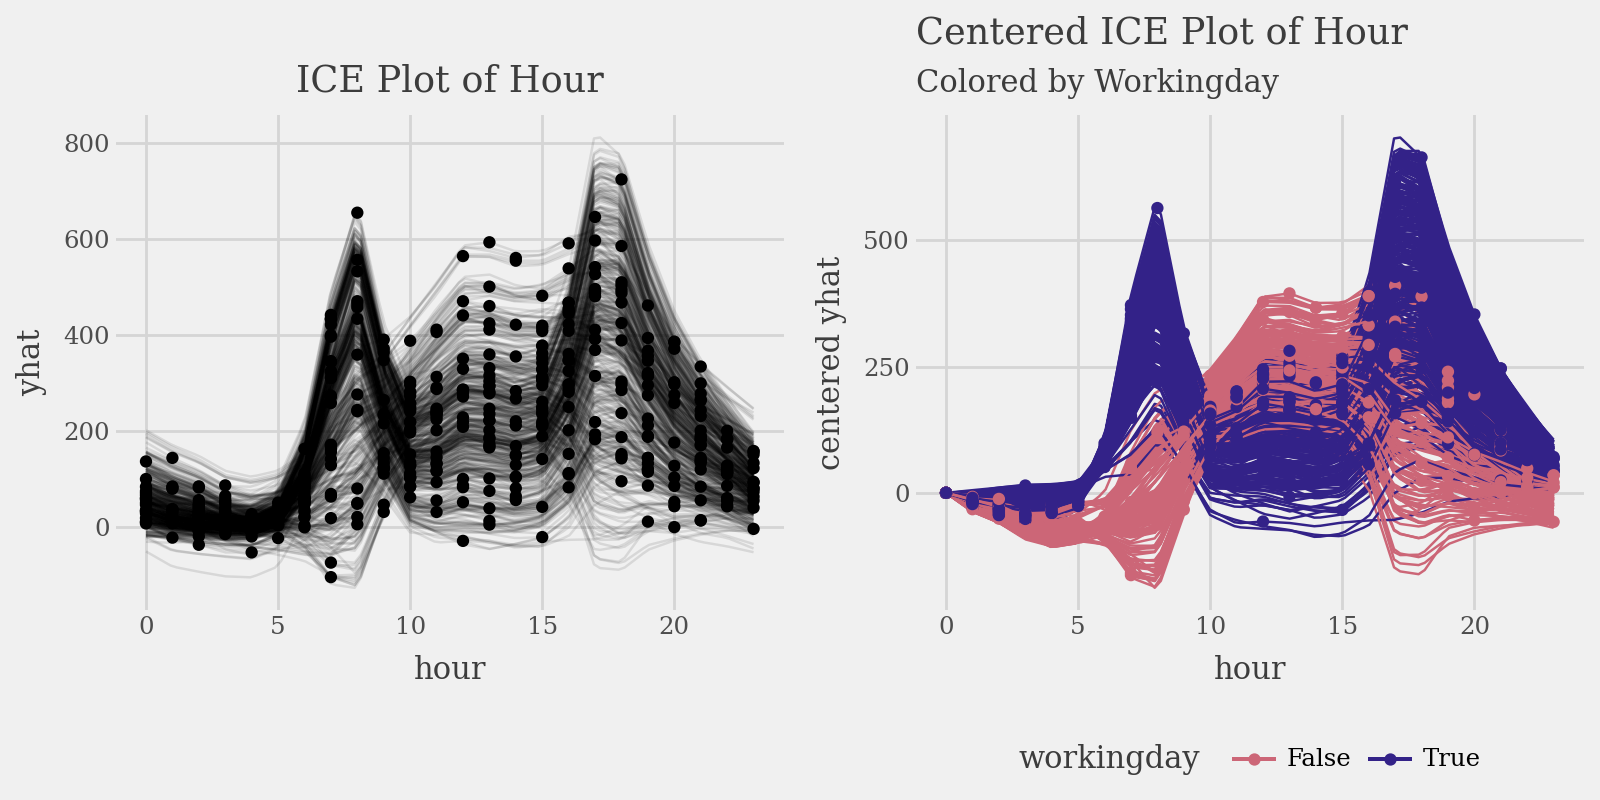

In [87]:
# Plot individual conditional expectations (ICE) with color encoding
ice = explainer.conditional(
    variable='hour',
    data=X_train.head(500)
)
p1 = (
    ice.plot(alpha=.1) +
    p9.ggtitle("ICE Plot of Hour")
)
p2 = (
    ice.plot(
        style='centered',
        var_color='workingday',
        theme='muted'
    ) +
    p9.labs(
        title="Centered ICE Plot of Hour",
        subtitle="Colored by Workingday"
    ) +
    p9.theme(legend_position="bottom")
)
display((p1 | p2) & p9.theme(figure_size=(8, 4), legend_position="bottom"))